In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate

## PHYS 512 - Problem Set 1
Tristan Ménard<br>
260675783
### Problem 1
b) (continued)

In [2]:
def FourPointDerivative(func, x, delta):
    return (-func(x+2*delta)+8*func(x+delta)-8*func(x-delta)+func(x+2*delta))/(12*delta)

def DeltaOpt(f, f_prime5, x, precision):
    return (precision*f(x)/(f_prime5(x)))**(1/5)

In [3]:
# Give the desired functions to numerically integrate:
f1 = lambda x: np.exp(x)
f2 = lambda x: np.exp(0.01*x)
# We will need the analytic 5th derivative of both these functions later on:
f1_prime5 = f1
f2_prime5 = lambda x: (0.01**5)*np.exp(0.01*x)

# Pick a x value to check the optimal delta estimate
x = 0.5
# Look at how the absolute error in the numerical derivative changes for values of delta between 10^-17 and 10^0
delta = np.logspace(-17,0,200)
# Compute the 4-point numerical derivative for the above delta values
f1_prime_num = FourPointDerivative(f1, x, delta)
f2_prime_num = FourPointDerivative(f2, x, delta)

# Check the numerical derivative against the exact analytic derivative
f1_prime_exact = np.exp(x)
f2_prime_exact = 0.01*np.exp(0.01*x)
AbsError1 = np.abs(f1_prime_exact-f1_prime_num)
AbsError2 = np.abs(f2_prime_exact-f2_prime_num)

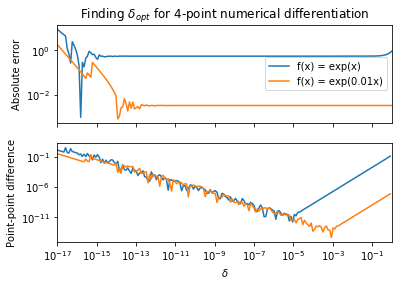

In [4]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
# Plot the absolute error in the numerical derivative
ax1.loglog(delta, AbsError1, label='f(x) = exp(x)')
ax1.loglog(delta, AbsError2, label='f(x) = exp(0.01x)')
# The absolute error appears to be quite flat -- but it isn't!
# The minimum will be where the difference between error points is smallest
ax2.loglog(delta[0:-1], np.abs(np.diff(AbsError1)))
ax2.loglog(delta[0:-1], np.abs(np.diff(AbsError2)))
ax1.legend(loc='best')
ax1.set_ylabel('Absolute error')
ax2.set_ylabel('Point-point difference')
ax2.set_xlabel(r'$\delta$')
ax1.set_title(r'Finding $\delta_{opt}$ for 4-point numerical differentiation')
plt.xlim(delta.min(),delta.max())
plt.show()

In [5]:
# What do I estimate the optimal delta to be?
delta_opt_1 = DeltaOpt(f1, f1_prime5, x, 1e-16)
delta_opt_2 = DeltaOpt(f2, f2_prime5, x, 1e-16)
print('delta_opt_1 = {:.5e}\ndelta_opt_2 = {:.5e}'.format(delta_opt_1, delta_opt_2)) # right order of magnitude!

delta_opt_1 = 6.30957e-04
delta_opt_2 = 6.30957e-02


### Problem 2

In [6]:
data = np.loadtxt('lakeshore.txt')
T = data[:,0] #K
V = data[:,1] #V
dVdT = data[:,2] #mV/K

# Data is ordered by ascending temperature; reorder it by ascending voltage
index = np.argsort(V)
V = V[index]
T = T[index]

In [7]:
def CubicSplineInterp(x, y, xi):
    """
    Returns the interpolated value(s) xi from a 1D cubic spline of your x and y data points.
    Also, computes the linear interpolation between data points for the same xi values.
    The absolute difference between the value(s) from the cubic spline interpolation (yi) and the value(s) from the linear interpolation (yi_linear) is returned as the rough error (yi_err).
    x : array-like
        The x data points to interpolate
    y : array-like
        The y data points to interpolate
    xi : float or array-like
        The value(s) of x where we want to interpolate new y value(s)
    """
    xi = np.asarray(xi)
    spln = interpolate.splrep(x, y)
    yi = interpolate.splev(xi, spln)
    linear = interpolate.interp1d(x, y, 'linear')
    yi_linear = linear(xi)
    yi_err = np.abs(yi_linear-yi) # because the baseline is a simple linear interpolation, the error is likely overestimated
    return yi, yi_err

In [8]:
xx = 1.0
yy, yy_err = CubicSplineInterp(V, T, xx)
print('The interpolated temperature for a voltage of {:}V is {:} +/- {:}K.'.format(xx, yy, yy_err))

The interpolated temperature for a voltage of 1.0V is 92.8996409775585 +/- 0.029361831417276107K.


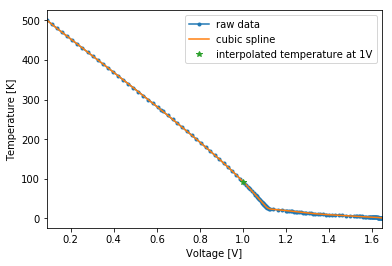

In [9]:
xx_full = np.linspace(V[0],V[-1],2001)
yy_full, yy_err_full = CubicSplineInterp(V, T, xx_full)

plt.plot(V, T, '.-', label='raw data')
plt.plot(xx_full, yy_full, label='cubic spline')
plt.plot(xx, yy, '*', label='interpolated temperature at 1V')
plt.xlim(V[0],V[-1])
plt.xlabel('Voltage [V]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.show()

### Problem 3

In [12]:
def better_integrate(fun, a, b, tol, y0_last=None, y2_last=None, y4_last=None, verbose=False):
    """
    A 5-point recursive variable step size integrator that does not call f(x) multiple times for the same x.
    fun : function
        The function for the integrand
    a : float
        The integration's start value
    b : float
        The integration's end value
    tol : float
        The difference between the 5-point and the 3-point integration must be smaller than this tolerance to be considered final
    y0_last : float or None (default)
        The first f(x) value that was passed from the previous iteration
    y2_last : float or None (default)
        The midpoint f(x) value that was passed from the previous iteration
    y4_last : float or None (default)
        The last f(x) value that was passed from the previous iteration
    """
    if y0_last is None: # only occurs for the first iteration
        x = np.linspace(a,b,5)
        y = fun(x)
        neval = len(x) # neval keeps track of the number of f(x) calls
    else:
        dx = (b-a)/4
        y = np.array([y0_last, fun(a+dx), y2_last, fun(a+3*dx), y4_last]) # uses f(x) values that were computed in the previous iteration
        neval = 2 # two new f(x) calls
    f1 = (y[0]+4*y[2]+y[4])/6*(b-a)
    f2 = (y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a) 
    myerr = np.abs(f2-f1)
    if verbose:
        print([a,b,f1,f2,y])
    if myerr<tol:
        return (16*f1-f2)/15, myerr, neval
    else:
        mid = 0.5*(b+a)
        f_left, err_left, neval_left = better_integrate(fun, a, mid, tol/2.0, y0_last=y[0], y2_last=y[1], y4_last=y[2], verbose=verbose)
        f_right, err_right, neval_right = better_integrate(fun, mid, b, tol/2.0, y0_last=y[2], y2_last=y[3], y4_last=y[4], verbose=verbose)
        neval = neval+neval_left+neval_right
        f = f_left+f_right
        err = err_left+err_right
        return f, err, neval

For comparison purposes, here is the simple recursive variable step size integrator we wrote in class.

In [13]:
def simple_integrate(fun,a,b,tol):
    x=np.linspace(a,b,5)
    dx=(b-a)/4.0
    y=fun(x)
    neval=len(x) #let's keep track of function evaluations
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)
    myerr=np.abs(f2-f1)
#     print([a,b,f1,f2])
    if (myerr<tol):
        return (16.0*f2-f1)/15.0,myerr,neval
    else:
        mid=0.5*(b+a)
        f_left,err_left,neval_left=simple_integrate(fun,a,mid,tol/2.0)
        f_right,err_right,neval_right=simple_integrate(fun,mid,b,tol/2.0)
        neval=neval+neval_left+neval_right
        f=f_left+f_right
        err=err_left+err_right
        return f,err,neval

Let's compare the number of function calls in each method for $f(x)=e^x$, $f(x)=\sin(x)$, and $f(x) = e^{-\frac{x^2}{2}}$.

### $ f(x)=e^x$

In [14]:
f_better, err_better, neval_better = better_integrate(np.exp, -1, 1, 1e-3, verbose=True) # set verbose to True to see the inner workings of the integrator
f_simple, err_simple, neval_simple = simple_integrate(np.exp, -1, 1, 1e-3)
pred = np.exp(1)-np.exp(-1)
print('\nBETTER_INTEGRATE: f,err,neval are ' + repr([f_better,err_better,neval_better])+' with err ' + repr(np.abs(f_better-pred)))
print('SIMPLE_INTEGRATE: f,err,neval are ' + repr([f_simple,err_simple,neval_simple])+' with err ' + repr(np.abs(f_simple-pred)))

[-1, 1, 2.362053756543496, 2.3511948318802554, array([0.36787944, 0.60653066, 1.        , 1.64872127, 2.71828183])]
[-1, 0.0, 0.6323336800036626, 0.6321341753205323, array([0.36787944, 0.47236655, 0.60653066, 0.77880078, 1.        ])]
[0.0, 1, 1.7188611518765928, 1.7183188419217472, array([1.        , 1.28402542, 1.64872127, 2.11700002, 2.71828183])]
[0.0, 0.5, 0.6487352447875911, 0.648722148950655, array([1.        , 1.13314845, 1.28402542, 1.45499141, 1.64872127])]
[0.5, 1, 1.069583597134156, 1.0695620057492419, array([1.64872127, 1.86824596, 2.11700002, 2.39887529, 2.71828183])]

BETTER_INTEGRATE: f,err,neval are [2.350668134719075, 0.00023419190498064069, 13] with err 0.0002657474314724517
SIMPLE_INTEGRATE: f,err,neval are [2.350402717226764, 0.00023419190498064069, 25] with err 3.299391613253988e-07


My new integrator requires 13 function evaluations while the old one requires 25.

### $f(x)=\sin(x)$

In [15]:
f_better, err_better, neval_better = better_integrate(np.sin, 0, np.pi, 1e-3) # set verbose to True to see the inner workings of the integrator
f_simple, err_simple, neval_simple = simple_integrate(np.sin, 0, np.pi, 1e-3)
pred = 2
print('BETTER_INTEGRATE: f,err,neval are ' + repr([f_better,err_better,neval_better])+' with err ' + repr(np.abs(f_better-pred)))
print('SIMPLE_INTEGRATE: f,err,neval are ' + repr([f_simple,err_simple,neval_simple])+' with err ' + repr(np.abs(f_simple-pred)))

BETTER_INTEGRATE: f,err,neval are [2.0002860085417513, 0.0002525789004523826, 17] with err 0.00028600854175131474
SIMPLE_INTEGRATE: f,err,neval are [1.999999752454572, 0.0002525789004523826, 35] with err 2.475454279338152e-07


My new integrator requires 17 function evaluations while the old one requires 35.

### $f(x)=e^{-\frac{x^2}{2}}$

In [16]:
fun = lambda x: np.exp(-x**2/2)
f_better, err_better, neval_better = better_integrate(fun, -1, 1, 1e-3) # set verbose to True to see the inner workings of the integrator
f_simple, err_simple, neval_simple = simple_integrate(fun, -1, 1, 1e-3)
pred = 0
print('BETTER_INTEGRATE: f,err,neval are ' + repr([f_better,err_better,neval_better]))
print('SIMPLE_INTEGRATE: f,err,neval are ' + repr([f_simple,err_simple,neval_simple]))

BETTER_INTEGRATE: f,err,neval are [1.7122307647876585, 0.0008701215598000411, 9]
SIMPLE_INTEGRATE: f,err,neval are [1.7112446270198851, 0.0008701215598000411, 15]


My new integrator requires 9 function evaluations while the old one requires 15.

So, for these functions, we see that somewhere around 40 to 50% less function evaluations are required.

### Problem 4

$$E(z)=\frac{1}{4\pi\epsilon_0}\frac{q}{2}\int_0^\pi \frac{(z-R\cos\theta)\sin\theta\ d\theta}{(z^2+R^2-2zR\cos\theta)^{3/2}}$$

There is a singularity in the integrand at $z=R$, but as demonstrated below, quad doesn't care and calculates the integral when $z=R$ to be equal to 1.

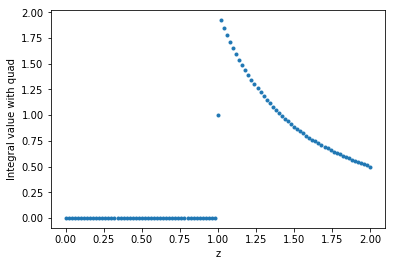

In [17]:
zs = np.linspace(0,2,101)
R = 1
q = 1
epsilon_0 = 1
integrand = lambda theta: (z-R*np.cos(theta))*np.sin(theta)/(z**2+R**2-2*z*R*np.cos(theta))**1.5

integral_quad = []
for i in range(len(zs)):
    z = zs[i]
    integral_quad.append(integrate.quad(integrand, 0, np.pi)[0])
    
plt.plot(zs, integral_quad, '.')
plt.xlabel('z')
plt.ylabel('Integral value with quad')
plt.show()

On the other hand, the custom recursive variable step size integrator I wrote in problem 3 is not able to calculate the value of the integral for $z=R$.

In [18]:
# using the same z values as before (includes z=R=1)
integral_custom = []
for i in range(len(zs)):
    z = zs[i]
    integral_custom.append(better_integrate(integrand, 0, np.pi, 1e-3, verbose=True)[0])

[0, 3.141592653589793, -6.412235645739299e-17, -8.420110503825788e-17, array([-0.0000000e+00, -5.0000000e-01, -6.1232340e-17,  5.0000000e-01,
        1.2246468e-16])]
[0, 3.141592653589793, 0.04186278186714407, -0.004324657618129748, array([-0.00000000e+00, -5.06911661e-01,  1.99880060e-02,  4.92787914e-01,
        1.17709227e-16])]
[0, 1.5707963267948966, -0.5256038022874031, -0.5010530929950175, array([-0.        , -0.36577157, -0.50691166, -0.34271052,  0.01998801])]
[0, 0.7853981633974483, -0.25787212667652354, -0.25722427687160154, array([-0.        , -0.19891279, -0.36577157, -0.47399787, -0.50691166])]
[0, 0.39269908169872414, -0.0760149402128647, -0.07600346146728267, array([-0.        , -0.10152665, -0.19891279, -0.28819774, -0.36577157])]
[0.39269908169872414, 0.7853981633974483, -0.1812093366587368, -0.18118325313434183, array([-0.36577157, -0.42852885, -0.47399787, -0.5004395 , -0.50691166])]
[0.7853981633974483, 1.5707963267948966, -0.2431809663184939, -0.2426965017253286,

[1.5707963267948966, 2.356194490192345, 0.2837833383501362, 0.2832471106033551, array([0.11745388, 0.28268309, 0.39914759, 0.45682872, 0.45390077])]
[1.5707963267948966, 1.9634954084936207, 0.107817748130467, 0.10779872538664298, array([0.11745388, 0.20518516, 0.28268309, 0.34784453, 0.39914759])]
[1.9634954084936207, 2.356194490192345, 0.17542936247288815, 0.17541569254472952, array([0.39914759, 0.43562577, 0.45682872, 0.46277496, 0.45390077])]
[2.356194490192345, 3.141592653589793, 0.21160748815788127, 0.21146173039502386, array([4.53900766e-01, 3.95213016e-01, 2.90665341e-01, 1.53703434e-01,
       9.76280930e-17])]
[0, 3.141592653589793, 0.28480126181858917, -0.02579616955503032, array([-0.00000000e+00, -5.38457199e-01,  1.35982586e-01,  4.45832378e-01,
        9.42325946e-17])]
[0, 1.5707963267948966, -0.5282709022084353, -0.49449757328255356, array([-0.        , -0.45194528, -0.5384572 , -0.25724257,  0.13598259])]
[0, 0.7853981633974483, -0.30712187704888155, -0.3052952948506161

C:\Users\Trix\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\Trix\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


[0, 7.786308038426783e-119, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 3.8931540192133913e-119, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 1.9465770096066957e-119, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 9.732885048033478e-120, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 4.866442524016739e-120, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 2.4332212620083696e-120, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 1.2166106310041848e-120, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 6.083053155020924e-121, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 3.041526577510462e-121, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 1.520763288755231e-121, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 7.603816443776155e-122, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 3.8019082218880775e-122, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 1.9009541109440387e-122, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 9.504770554720194e-123, nan, nan, array([nan, nan, nan

[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, nan])]
[0, 0.0, nan, nan, array([nan, nan, nan, nan, 

RecursionError: maximum recursion depth exceeded

But it still works fine when $z\neq R$.

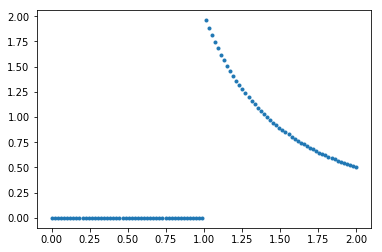

In [41]:
zs_new = np.linspace(0,2,100) # does not include z=R=1
integral_custom = []
for i in range(len(zs_new)):
    z = zs_new[i]
    integral_custom.append(better_integrate(integrand, 0, np.pi, 1e-3)[0])
    
plt.plot(zs_new, integral_custom, '.')
plt.show()